# Modelling

## Packages

In [20]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import winsound
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, normalize
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import joblib

import xgboost

import tensorflow
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
#from tensorflow.nn import relu, softmax

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt

print(f" Found and Using {len(tensorflow.config.experimental.list_physical_devices('GPU'))} GPU")

 Found and Using 1 GPU


## Functions

In [2]:
def scale_x_encode_y(x, y):

    scaler_obj = StandardScaler()
    #scaler_obj = MinMaxScaler()
    scaler_obj.fit(x.values)
    x_scaled = scaler_obj.transform(x.values)
    #x_scaled = x.values
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_encoded = utils.to_categorical(y_encoded)
    
    y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
 
    return(x_scaled, y_encoded, y_map, scaler_obj)


def smote_data(x, y):
    oversample = SMOTE()
    smote_x, smote_y = oversample.fit_resample(x, y)
    return(smote_x, smote_y)


def data_prep(df, apply_smote = False):
    x = df.loc[:, df.columns != target_col]
    y = df[target_col]

    if apply_smote:
        x, y = smote_data(x, y)

    print(f'Record count : {len(y)}')
    print('--------------------------')
    print(y.value_counts())
    print('--------------------------')
    print(y.value_counts(normalize=True))
    
    x_scaled, y_encoded, y_map, scaler_obj = scale_x_encode_y(x, y)
    pd.DataFrame(x_scaled).head()
    
    return(x_scaled, y_encoded, y_map, scaler_obj)

## Read Data

In [3]:
#remove_cols = ['tick_avg', 'sema', 'ssma', 'lema', 'lsma', 'max_tick', 'min_tick', 'small_sema_slope', 'long_sema_slope']
remove_cols = ['tick_avg', 'sema', 'ssma', 'lema', 'lsma', 'max_tick', 'min_tick']

In [4]:
file_name = 'tab_tick'
#file_name = 'full_tab_tick'

In [5]:
#df1 = pd.read_csv('data/'+file_name+'_2017.csv')
#df2 = pd.read_csv('data/'+file_name+'_2018.csv')
#df = df1.append(df2, ignore_index=True)

df = pd.read_csv('data/'+file_name+'_2019.csv')

df.drop(remove_cols, axis=1, inplace=True)
df.head(5)

,spread_avg,tick_sd,sema_diff,lema_diff,diff,avg_gain,avg_loss,rs,rsi,ssma_diff,lsma_diff,sma_diff,max_gap,min_gap,small_sema_slope,long_sema_slope,ema_diff,direction
0,0.000041,0.000004,-0.000044,-0.000015,-0.000009,0.000003,0.000042,0.070397,6.576755,-0.000043,-0.000003,-0.000107,0.000453,0.0,-76.919403,33.776008,-0.000207,decrease
1,0.000047,0.000011,-0.000039,-0.000015,-0.000019,0.000003,0.000042,0.070583,6.592970,-0.000044,-0.000004,-0.000148,0.000472,0.0,-78.124047,29.783567,-0.000231,decrease
2,0.000035,0.000023,-0.000043,-0.000016,-0.000048,0.000002,0.000045,0.051753,4.920611,-0.000052,-0.000004,-0.000195,0.000488,0.0,-78.726125,24.840308,-0.000258,decrease
3,0.000041,0.000057,-0.000066,-0.000023,-0.000149,0.000002,0.000054,0.043435,4.162707,-0.000064,-0.000007,-0.000252,0.000569,0.0,-79.097933,18.628067,-0.000301,decrease
4,0.000045,0.000024,-0.000079,-0.000028,-0.000130,0.000002,0.000058,0.040463,3.888955,-0.000070,-0.000010,-0.000312,0.000663,0.0,-79.453374,10.976799,-0.000353,decrease


## -----------------------------------

In [ ]:
%%time
target_col = 'direction'
x = df.loc[:, df.columns != target_col]
y = df[target_col]
train_x, valid_x, train_y, valid_y = train_test_split(x, y,train_size = 0.8,random_state = 1)

alg = xgboost.XGBClassifier()
#clf_xg = xgboost.XGBClassifier()
clf_xg = GridSearchCV(alg,{'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, 
                    verbose=2, 
                    scoring='neg_log_loss',
                     n_jobs = -1)


clf_xg.fit(train_x, train_y)

print(clf_xg.best_score_, clf_xg.best_params_)

joblib.dump(clf_xg, 'data/model/model_xg.pkl') 

predictions = clf_xg.predict(valid_x)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(valid_y, predictions))

In [29]:
clf_xg = xgboost.XGBClassifier()

clf_xg.fit(train_x, train_y)
joblib.dump(clf_xg, 'data/model/model_xg.pkl') 

predictions = clf_xg.predict(valid_x)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(valid_y, predictions))

[13:27:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

    decrease       0.78      0.82      0.80     21887
    increase       0.78      0.83      0.80     22017
        same       0.54      0.44      0.48     14458

    accuracy                           0.73     58362
   macro avg       0.70      0.70      0.70     58362
weighted avg       0.72      0.73      0.72     58362



In [31]:
clf_xg.get_xgb_params()

{'objective': 'multi:softprob',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 12,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

## -----------------------------------

<AxesSubplot:>

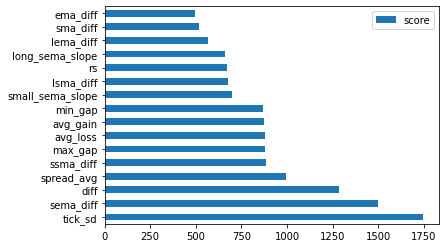

In [7]:
feature_important = clf_xg.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

              precision    recall  f1-score   support

    decrease       0.79      0.85      0.82    110264
    increase       0.78      0.86      0.82    109156
        same       0.43      0.22      0.29     41010

    accuracy                           0.75    260430
   macro avg       0.66      0.64      0.64    260430
weighted avg       0.73      0.75      0.73    260430

Wall time: 8.84 s


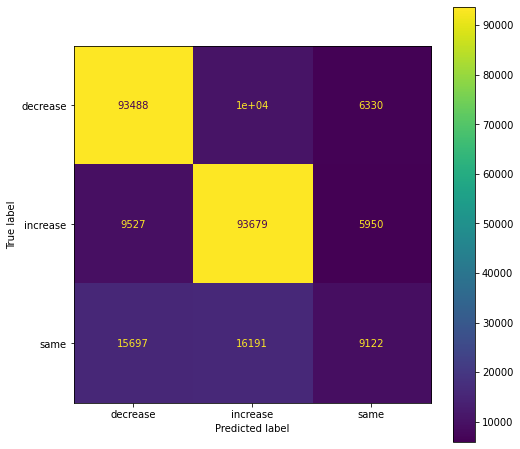

In [19]:
%%time
df1 = pd.read_csv('data/'+file_name+'_2018.csv')
df1.drop(remove_cols, axis=1, inplace=True)
x = df1.loc[:, df1.columns != target_col]
y = df1[target_col]

clf_xg = joblib.load('data/model/model_xg.pkl') 
predictions = clf_xg.predict(x)

df1['predictions'] = predictions
#df1.to_csv('data/'+file_name+'_2018_res.csv')

print(classification_report(y, predictions))

fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y, predictions, labels=clf_xg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_xg.classes_)
disp.plot(ax=ax)

%%time
df1 = pd.read_csv('data/'+file_name+'_2017.csv')
df1.drop(remove_cols, axis=1, inplace=True)
x = df1.loc[:, df1.columns != target_col]
y = df1[target_col]

clf_xg = joblib.load('data/model/model_xg.pkl') 
predictions = clf_xg.predict(x)

df1['predictions'] = predictions
#df1.to_csv('data/'+file_name+'_2018_res.csv')

print(classification_report(y, predictions))

fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y, predictions, labels=clf_xg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_xg.classes_)
disp.plot(ax=ax)

live_df = pd.read_csv('data/live_preds.csv')
live_df.drop(remove_cols, axis=1, inplace=True)
del live_df['predicted_direction']

scaler_obj = joblib.load('data/model/scaler_obj.pkl')
y_map = joblib.load('data/model/y_map.pkl') 
x_scaled = scaler_obj.transform(live_df.values)

predictions = clf_xg.predict(x_scaled)

live_df['predictions'] = [y_map[k] for k in predictions]

print(y_map)
live_df['predictions'].value_counts()

In [10]:
winsound.PlaySound('C:\\Windows\\Media\\tada.wav', winsound.SND_ASYNC)